In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
# Build the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(stoi)

print ( itos )

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# Build the dataset
block_size = 3

def build_dataset(words):
    X,Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
def cmp(s,dt,t):
    assert dt.shape==t.grad.shape, "Inputs must have same size"
    ex = torch.all(dt==t.grad).item()
    app = torch.allclose(dt,t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print ( f'{s:15s}, exact: {str(ex):5s}, approximate: {str(app):5s}, maxdiff: {maxdiff}')


In [6]:
# Init the parameters

n_embed = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed), generator=g)
 
W1 = torch.rand((n_embed*block_size,n_hidden), generator=g) * (5/3) / ((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1

W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

bngain = torch.randn((1,n_hidden))*0.1 + 1.0
bnbias = torch.randn((1,n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))

4137


In [7]:
batch_size = 32
n = batch_size

ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
Xb,Yb = Xtr[ix], Ytr[ix]

In [8]:
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

hprebn = embcat @ W1 + b1
hprebn.retain_grad() # Not shure why I had to put this on this one only....

bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*bndiff2.sum(0,keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv

hpreact = bngain*bnraw + bnbias

h = torch.tanh(hpreact)

logits = h @ W2 + b2

logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes

counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

#Pytorch backwards
for p in parameters:
    p.grad = None

for t in [logprobs,probs,counts,counts_sum,counts_sum_inv,
         norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, bnmeani, embcat, emb]:
    t.retain_grad()

loss.backward()
loss    

tensor(3.4063, grad_fn=<NegBackward0>)

In [9]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = probs**-1 * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1,keepdim=True)
dcounts_sum = -counts_sum**-2 * dcounts_sum_inv
dcounts = counts_sum_inv * dprobs + torch.ones_like(counts) * dcounts_sum 
dnorm_logits = norm_logits.exp() * dcounts
dlogit_maxes = -dnorm_logits.sum(1,keepdim=True)
dlogits = 1 * dnorm_logits.clone() + F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1-h**2)*dh 
dbngain = (bnraw*dhpreact).sum(0, keepdim=True)
dbnraw = bngain*dhpreact
dbnbias = dhpreact.sum(0,keepdim=True)
dbnvar_inv = (bndiff*dbnraw).sum(0,keepdim=True)
dbnvar = -0.5*(bnvar+1e-5)**-1.5*dbnvar_inv
dbndiff2 = 1/(n-1)*torch.ones_like(bndiff2)*dbnvar
dbndiff = bnvar_inv*dbnraw + 2*bndiff*dbndiff2
dbnmeani = -dbndiff.sum(0,keepdim=True)
dhprebn = dbndiff.clone() + 1/n*dbnmeani*torch.ones_like(hprebn)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]        

cmp( 'logprobs', dlogprobs, logprobs )
cmp( 'probs', dprobs, probs )
cmp( 'counts_sum_inv', dcounts_sum_inv, counts_sum_inv )
cmp( 'counts_sum', dcounts_sum, counts_sum )
cmp( 'counts', dcounts, counts )
cmp( 'norm_logits', dnorm_logits, norm_logits )
cmp( 'logit_maxes', dlogit_maxes, logit_maxes )
cmp( 'logits', dlogits, logits )
cmp( 'h', dh, h )
cmp( 'W2', dW2, W2 )
cmp( 'b2', db2, b2 )
cmp( 'h', dh, h )
cmp( 'bngain', dbngain, bngain )
cmp( 'bnraw', dbnraw, bnraw )
cmp( 'bnbias', dbnbias, bnbias )
cmp( 'bnvar_inv', dbnvar_inv, bnvar_inv )
cmp( 'bnvar', dbnvar, bnvar )
cmp( 'bndiff2', dbndiff2, bndiff2 )
cmp( 'bndiff', dbndiff, bndiff )
cmp( 'bnmeani', dbnmeani, bnmeani )
cmp( 'hprebn', dhprebn, hprebn )
cmp( 'embcat', dembcat, embcat )
cmp( 'W1', dW1, W1 )
cmp( 'b1', db1, b1 )
cmp( 'emb', demb, emb)
cmp( 'C', dC, C)


logprobs       , exact: True , approximate: True , maxdiff: 0.0
probs          , exact: True , approximate: True , maxdiff: 0.0
counts_sum_inv , exact: True , approximate: True , maxdiff: 0.0
counts_sum     , exact: True , approximate: True , maxdiff: 0.0
counts         , exact: True , approximate: True , maxdiff: 0.0
norm_logits    , exact: True , approximate: True , maxdiff: 0.0
logit_maxes    , exact: True , approximate: True , maxdiff: 0.0
logits         , exact: True , approximate: True , maxdiff: 0.0
h              , exact: True , approximate: True , maxdiff: 0.0
W2             , exact: True , approximate: True , maxdiff: 0.0
b2             , exact: True , approximate: True , maxdiff: 0.0
h              , exact: True , approximate: True , maxdiff: 0.0
bngain         , exact: True , approximate: True , maxdiff: 0.0
bnraw          , exact: True , approximate: True , maxdiff: 0.0
bnbias         , exact: True , approximate: True , maxdiff: 0.0
bnvar_inv      , exact: True , approxima

In [ ]:
# Simplify the loss function

In [15]:
#Forward pass
loss_fast = F.cross_entropy(logits,Yb)
print ( loss_fast.item(), 'diff: ', (loss_fast - loss).item())

3.406278371810913 diff:  -2.384185791015625e-07


In [19]:
# Backwards pass
dlogits = F.softmax(logits,1)
dlogits[range(n),Yb] -= 1
dlogits /= n


cmp( 'logits', dlogits, logits)

logits         , exact: False, approximate: True , maxdiff: 6.984919309616089e-09


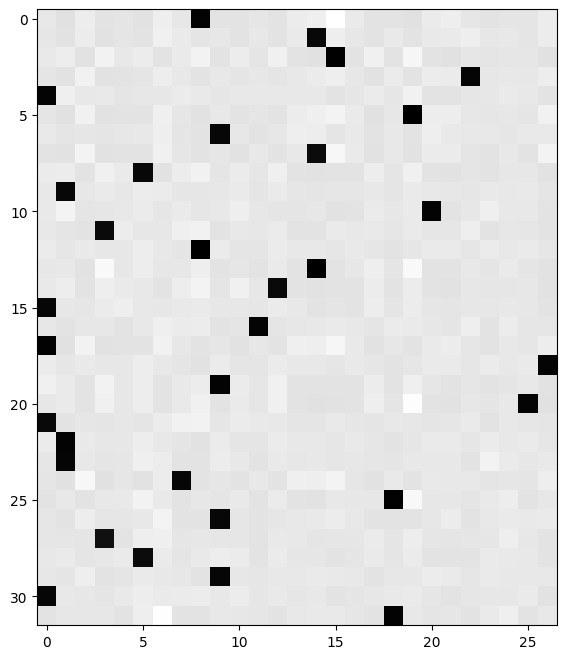

In [22]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray');

In [39]:
# Excercise 3: Backprop through batchnorm

# Forward pass
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [40]:
# Backward pass
dhprebn = bngain * bnvar_inv / n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp( 'hprebn', dhprebn, hprebn)

hprebn         , exact: False, approximate: True , maxdiff: 1.3969838619232178e-09
